In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


**Set** **Hyperparameters**

In [3]:
FILEPATH = '/content/drive/MyDrive/archive' # filepath for data
BATCH_SIZE = 64 # keras training batch size
IMAGE_SIZE = (224, 224) # size of images in dataset (keras will resize)

MODEL_CHECKPOINT_FILEPATH = './Fruits-Vegetables-Classifier-Model-Checkpoint.ckpt'

SEED = 6278 # random seed for repeatability of notebook

**Load Datasets** **and** **Data Augmentation** 

In [10]:
# Training Dataset
train_path = FILEPATH + '/train/'

# Validation Dataset
valid_path = FILEPATH + '/validation/'

# Test Dataset
test_path = FILEPATH + '/test/'

# Generate Training Data
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  horizontal_flip=True,
                                  shear_range=True,
                                  rotation_range=40,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2
                                )
train_data = train_datagen.flow_from_directory(train_path,
                                               target_size=IMAGE_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')
                                                

# Generate Validation Data
valid_datagen = ImageDataGenerator(rescale=1/255.)

valid_data = valid_datagen.flow_from_directory(valid_path,
                                               target_size=IMAGE_SIZE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')

# Generate Test Data
test_datagen = ImageDataGenerator(rescale=1/255.)

test_data = test_datagen.flow_from_directory(test_path,
                                             target_size=IMAGE_SIZE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Found 3122 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


**Visualize Data Samples**

Found 3122 files belonging to 36 classes.


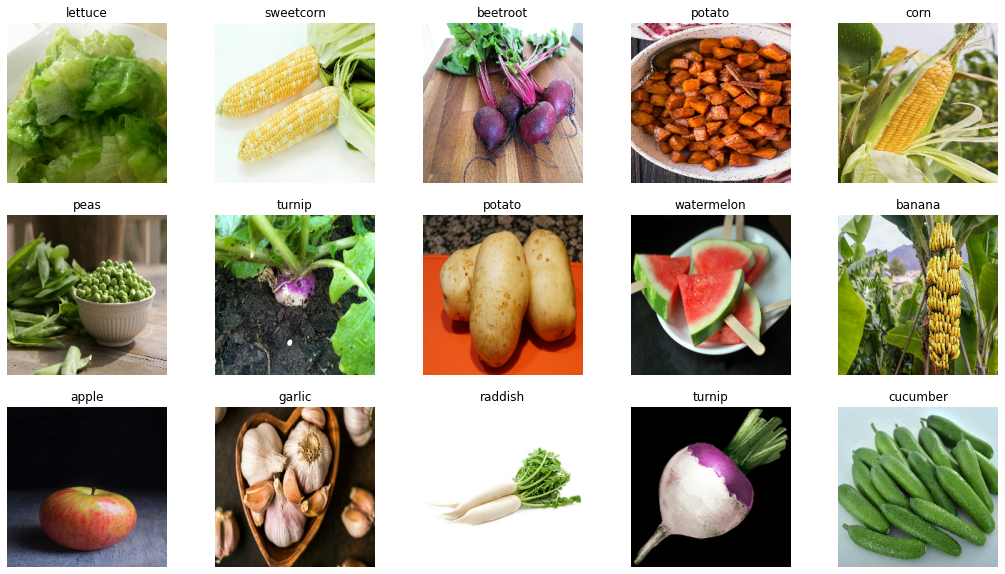

In [23]:
train = image_dataset_from_directory(directory = FILEPATH + '/train/',
                                     shuffle = True,
                                     labels='inferred',
                                     label_mode='categorical',
                                     batch_size = BATCH_SIZE,
                                     image_size = IMAGE_SIZE,
                                     seed = SEED)

class_names = train.class_names
plt.figure(figsize=(18, 10))

for images, labels in train.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

**Import ResNetV2 Base Model**

In [12]:
IMAGE_SHAPE = IMAGE_SIZE + (3,)

from keras.applications.resnet_v2 import ResNet101V2
from keras.models import Model

resnet_v2 = ResNet101V2(weights='imagenet',include_top=False,input_shape=IMAGE_SHAPE)

for layer in resnet_v2.layers:
    layer.trainable = False

171317808/171317808 [==============================] - 8s 0us/step


In [13]:
base_model = resnet_v2.output
base_model = layers.Flatten()(base_model)
base_model = layers.Dense(512,activation='relu')(base_model)
base_model = layers.Dense(512,activation='relu')(base_model)
base_model = layers.Dense(36,activation='softmax')(base_model)

**Build Model**

In [14]:
model = Model(inputs=resnet_v2.input,outputs=base_model)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

**Train Model**

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [16]:
es = EarlyStopping(monitor='val_accuracy',patience=90,verbose=1,mode='max')
mc = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,min_lr=0.001,patience=15,mode='max',verbose=1)

r = model.fit(train_data,
              epochs= 30,
              batch_size=32,
              validation_data=valid_data,
              callbacks=[es,mc,lr])

Epoch 1/30
49/49 [==============================] - ETA: 0s - loss: 17.1446 - accuracy: 0.3847 
Epoch 1: val_accuracy improved from -inf to 0.73789, saving model to ./Fruits-Vegetables-Classifier-Model-Checkpoint.ckpt


49/49 [==============================] - 2147s 44s/step - loss: 17.1446 - accuracy: 0.3847 - val_loss: 0.8531 - val_accuracy: 0.7379 - lr: 0.0010
Epoch 2/30
49/49 [==============================] - ETA: 0s - loss: 1.8765 - accuracy: 0.5657
Epoch 2: val_accuracy did not improve from 0.73789
49/49 [==============================] - 169s 3s/step - loss: 1.8765 - accuracy: 0.5657 - val_loss: 1.0369 - val_accuracy: 0.7379 - lr: 0.0010
Epoch 3/30
49/49 [==============================] - ETA: 0s - loss: 1.6848 - accuracy: 0.6073
Epoch 3: val_accuracy improved from 0.73789 to 0.79487, saving model to ./Fruits-Vegetables-Classifier-Model-Checkpoint.ckpt


49/49 [==============================] - 202s 4s/step - loss: 1.6848 - accuracy: 0.6073 - val_loss: 0.7857 - val_accuracy: 0.7949 - lr: 0.0010
Epoch 4/30
49/49 [==============================] - ETA: 0s - loss: 1.4656 - accuracy: 0.6464
Epoch 4: val_accuracy improved from 0.79487 to 0.81481, saving model to ./Fruits-Vegetables-Classifier-Model-Checkpoint.ckpt


49/49 [==============================] - 201s 4s/step - loss: 1.4656 - accuracy: 0.6464 - val_loss: 0.7591 - val_accuracy: 0.8148 - lr: 0.0010
Epoch 5/30
49/49 [==============================] - ETA: 0s - loss: 1.3144 - accuracy: 0.6883
Epoch 5: val_accuracy improved from 0.81481 to 0.84046, saving model to ./Fruits-Vegetables-Classifier-Model-Checkpoint.ckpt


49/49 [==============================] - 199s 4s/step - loss: 1.3144 - accuracy: 0.6883 - val_loss: 0.6689 - val_accuracy: 0.8405 - lr: 0.0010
Epoch 6/30
49/49 [==============================] - ETA: 0s - loss: 1.2682 - accuracy: 0.7012
Epoch 6: val_accuracy improved from 0.84046 to 0.84900, saving model to ./Fruits-Vegetables-Classifier-Model-Checkpoint.ckpt


49/49 [==============================] - 200s 4s/step - loss: 1.2682 - accuracy: 0.7012 - val_loss: 0.6099 - val_accuracy: 0.8490 - lr: 0.0010
Epoch 7/30
49/49 [==============================] - ETA: 0s - loss: 1.1182 - accuracy: 0.7303
Epoch 7: val_accuracy improved from 0.84900 to 0.85755, saving model to ./Fruits-Vegetables-Classifier-Model-Checkpoint.ckpt


49/49 [==============================] - 200s 4s/step - loss: 1.1182 - accuracy: 0.7303 - val_loss: 0.5534 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 8/30
49/49 [==============================] - ETA: 0s - loss: 1.0591 - accuracy: 0.7457
Epoch 8: val_accuracy improved from 0.85755 to 0.88034, saving model to ./Fruits-Vegetables-Classifier-Model-Checkpoint.ckpt


49/49 [==============================] - 201s 4s/step - loss: 1.0591 - accuracy: 0.7457 - val_loss: 0.4701 - val_accuracy: 0.8803 - lr: 0.0010
Epoch 9/30
49/49 [==============================] - ETA: 0s - loss: 0.9884 - accuracy: 0.7575
Epoch 9: val_accuracy did not improve from 0.88034
49/49 [==============================] - 170s 3s/step - loss: 0.9884 - accuracy: 0.7575 - val_loss: 0.5537 - val_accuracy: 0.8632 - lr: 0.0010
Epoch 10/30
49/49 [==============================] - ETA: 0s - loss: 0.9734 - accuracy: 0.7646
Epoch 10: val_accuracy improved from 0.88034 to 0.88889, saving model to ./Fruits-Vegetables-Classifier-Model-Checkpoint.ckpt


49/49 [==============================] - 202s 4s/step - loss: 0.9734 - accuracy: 0.7646 - val_loss: 0.5037 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 11/30
49/49 [==============================] - ETA: 0s - loss: 0.9266 - accuracy: 0.7803
Epoch 11: val_accuracy did not improve from 0.88889
49/49 [==============================] - 165s 3s/step - loss: 0.9266 - accuracy: 0.7803 - val_loss: 0.4955 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 12/30
49/49 [==============================] - ETA: 0s - loss: 0.8852 - accuracy: 0.7908
Epoch 12: val_accuracy did not improve from 0.88889
49/49 [==============================] - 171s 3s/step - loss: 0.8852 - accuracy: 0.7908 - val_loss: 0.4934 - val_accuracy: 0.8775 - lr: 0.0010
Epoch 13/30
49/49 [==============================] - ETA: 0s - loss: 0.8075 - accuracy: 0.8027
Epoch 13: val_accuracy did not improve from 0.88889
49/49 [==============================] - 169s 3s/step - loss: 0.8075 - accuracy: 0.8027 - val_loss: 0.5099 - val_accuracy: 0.8689 

49/49 [==============================] - 199s 4s/step - loss: 0.7540 - accuracy: 0.8104 - val_loss: 0.5649 - val_accuracy: 0.9088 - lr: 0.0010
Epoch 15/30
49/49 [==============================] - ETA: 0s - loss: 0.7738 - accuracy: 0.8107
Epoch 15: val_accuracy improved from 0.90883 to 0.91168, saving model to ./Fruits-Vegetables-Classifier-Model-Checkpoint.ckpt


49/49 [==============================] - 202s 4s/step - loss: 0.7738 - accuracy: 0.8107 - val_loss: 0.4195 - val_accuracy: 0.9117 - lr: 0.0010
Epoch 16/30
49/49 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.8286
Epoch 16: val_accuracy improved from 0.91168 to 0.92023, saving model to ./Fruits-Vegetables-Classifier-Model-Checkpoint.ckpt


49/49 [==============================] - 201s 4s/step - loss: 0.6736 - accuracy: 0.8286 - val_loss: 0.5069 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 17/30
49/49 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.8261
Epoch 17: val_accuracy did not improve from 0.92023
49/49 [==============================] - 168s 3s/step - loss: 0.6873 - accuracy: 0.8261 - val_loss: 0.4651 - val_accuracy: 0.9088 - lr: 0.0010
Epoch 18/30
49/49 [==============================] - ETA: 0s - loss: 0.6135 - accuracy: 0.8402
Epoch 18: val_accuracy did not improve from 0.92023
49/49 [==============================] - 167s 3s/step - loss: 0.6135 - accuracy: 0.8402 - val_loss: 0.4171 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 19/30
49/49 [==============================] - ETA: 0s - loss: 0.6263 - accuracy: 0.8437
Epoch 19: val_accuracy improved from 0.92023 to 0.93162, saving model to ./Fruits-Vegetables-Classifier-Model-Checkpoint.ckpt


49/49 [==============================] - 207s 4s/step - loss: 0.6263 - accuracy: 0.8437 - val_loss: 0.4099 - val_accuracy: 0.9316 - lr: 0.0010
Epoch 20/30
49/49 [==============================] - ETA: 0s - loss: 0.5536 - accuracy: 0.8479
Epoch 20: val_accuracy did not improve from 0.93162
49/49 [==============================] - 169s 3s/step - loss: 0.5536 - accuracy: 0.8479 - val_loss: 0.5562 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 21/30
49/49 [==============================] - ETA: 0s - loss: 0.5788 - accuracy: 0.8459
Epoch 21: val_accuracy did not improve from 0.93162
49/49 [==============================] - 166s 3s/step - loss: 0.5788 - accuracy: 0.8459 - val_loss: 0.5060 - val_accuracy: 0.9117 - lr: 0.0010
Epoch 22/30
49/49 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.8607
Epoch 22: val_accuracy did not improve from 0.93162
49/49 [==============================] - 169s 3s/step - loss: 0.4956 - accuracy: 0.8607 - val_loss: 0.4291 - val_accuracy: 0.9088 

49/49 [==============================] - 203s 4s/step - loss: 0.5251 - accuracy: 0.8629 - val_loss: 0.3511 - val_accuracy: 0.9345 - lr: 0.0010
Epoch 25/30
49/49 [==============================] - ETA: 0s - loss: 0.5378 - accuracy: 0.8571
Epoch 25: val_accuracy improved from 0.93447 to 0.94302, saving model to ./Fruits-Vegetables-Classifier-Model-Checkpoint.ckpt


49/49 [==============================] - 208s 4s/step - loss: 0.5378 - accuracy: 0.8571 - val_loss: 0.2915 - val_accuracy: 0.9430 - lr: 0.0010
Epoch 26/30
49/49 [==============================] - ETA: 0s - loss: 0.4730 - accuracy: 0.8786
Epoch 26: val_accuracy did not improve from 0.94302
49/49 [==============================] - 164s 3s/step - loss: 0.4730 - accuracy: 0.8786 - val_loss: 0.4209 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 27/30
49/49 [==============================] - ETA: 0s - loss: 0.4930 - accuracy: 0.8770
Epoch 27: val_accuracy did not improve from 0.94302
49/49 [==============================] - 168s 3s/step - loss: 0.4930 - accuracy: 0.8770 - val_loss: 0.3545 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 28/30
49/49 [==============================] - ETA: 0s - loss: 0.4982 - accuracy: 0.8741
Epoch 28: val_accuracy did not improve from 0.94302
49/49 [==============================] - 165s 3s/step - loss: 0.4982 - accuracy: 0.8741 - val_loss: 0.4956 - val_accuracy: 0.9288 

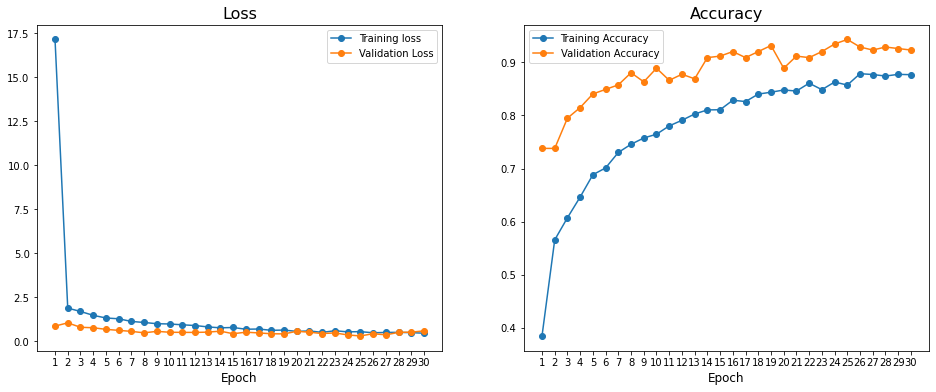

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs = 30

ax1.plot(range(1, total_epochs + 1), r.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), r.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), r.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), r.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

**Evaluate Model Accuracy on Test Data**

In [18]:
model.load_weights(MODEL_CHECKPOINT_FILEPATH)

test_loss, test_accuracy = model.evaluate(test_data)

print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(round(100*test_accuracy,1)) + '\033[0m')

6/6 [==============================] - 187s 37s/step - loss: 0.2853 - accuracy: 0.9443

The model had an accuracy score of 94.4%!!
